### Ten RDKit Tricks You Might Not Know 
<img src="robot_dog.png" width="400"/>
A recent comment on LinkedIn asked about "beyond the basics" RDKit tutorials.  This post isn't a proper tutorial, but does highlight a few intermediate to advanced tricks that some may find useful. Hopefully you'll find one or two things you haven't tried before.  The tips below range from one liners to slightly more complex examples.  However, most are less than a dozen lines of code. If you have additional RDKit tricks to share, please leave a comment.    

[1. Make structures look better](#1.-Make-structures-look-better)   
[2. Temporarily disable logging](#2.-Temporarily-disable-logging)     
[3. Turn off highlighting after a substructure search](#3.-Turn-off-highlighting-after-a-substructure-search)      
[4. Align a set of stuctures based on their Maxium Common Substructure (MCS)](#4.-Align-a-set-of-stuctures-based-on-their-Maxium-Common-Substructure)   
[5. Get the Maximum Common Substructure (MCS) as SMILES](#5.-Get-the-Maximum-Common-Substructure-as-SMILES)   
[6. Assign bond orders to a PDB Ligand](#6.-Assign-Bond-Orders-to-a-PDB-Ligand)   
[7. Display Cahn-Ingold-Prelog stereochemistry](#7.-Display-Cahn-Ingold-Prelog-Stereochemistry)   
[8. Get the largest fragment in a molecule](#8.-Get-the-largest-fragment-in-a-molecule)   
[9. Create an R-Group table](#9.-Create-an-R-Group-Table)    
[10. Show chemical structures and plots in a Pandas dataframe](#10.-Show-chemical-structures-and-plots-in-a-Pandas-dataframe)

Note that each example it self contained, with the necessary imports in the first code cell. 

<a id='make_structures_look_better'></a>
#### 1. Make structures look better
The standard RDKit depiction code is pretty good, but sometimes the aesthetics leave a bit to be desired.  We can often dramatically improve the depiction quality with a couple lines of code.  There are two critical variables. 
- `IPythonConsole.ipython_useSVG` - tells the RDKit to draw structures and Scalable Vector Graphics (SVG) instead of images
- `rdDepictor.SetPreferCoordGen` - tells the RDKit to use its alternate coordinate generator, which often produces better quality structures.
  
Let's begin with the default state,  which depicts structures as images using the default coordinate generator. 

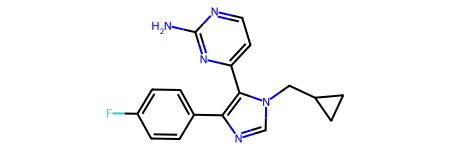

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdDepictor

IPythonConsole.ipython_useSVG = False
rdDepictor.SetPreferCoordGen(False)
mol = Chem.MolFromSmiles("c1cc(ccc1c2c(n(cn2)CC3CC3)c4ccnc(n4)N)F")
mol

Adding these two lines makes the structure look better. 

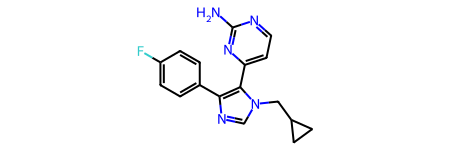

In [2]:
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
mol

#### 2. Temporarily disable logging 
The logging feature in the RDKit can often be useful. However, there are occasions when it can be a bit to chatty and you just want it to shut the hell up.  This becomes particularly acute when using rdMolStandardize, which can be quite verbose.   Here's the default behavior of `rdMolStandardize`.

In [3]:
from rdkit.Chem.MolStandardize import rdMolStandardize

std_smiles = rdMolStandardize.StandardizeSmiles("c1cc(ccc1c2c(n(cn2)CC3CC3)c4ccnc(n4)N)F")

[11:32:04] Initializing MetalDisconnector
[11:32:04] Running MetalDisconnector
[11:32:04] Initializing Normalizer
[11:32:04] Running Normalizer


This is not terrible, but if we're running through a large set of molecules, we'll end up with pages of messages.  A quick way to get rid of this is by using `rdBase.BlockLogs`.  Note the use of a [context manager](https://realpython.com/python-with-statement/) using the `with` statement. This only turns logging off within the indented block.  This way, you don't have to turn logging back on. 

In [4]:
from rdkit.rdBase import BlockLogs
with BlockLogs():
    std_smiles = rdMolStandardize.StandardizeSmiles("c1cc(ccc1c2c(n(cn2)CC3CC3)c4ccnc(n4)N)F")

#### 3. Turn off highlighting after a substructure search
The `GetSubstructMatch` and `GetSubStructMatches` functions conveniently highlight the matching substructure when the a structure is drawn.  However, sometimes you want to be able to display the structure without the hightlight.  

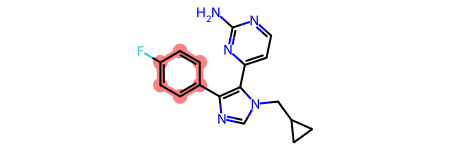

In [5]:
mol = Chem.MolFromSmiles("c1cc(ccc1c2c(n(cn2)CC3CC3)c4ccnc(n4)N)F")
qmol = Chem.MolFromSmarts("c1ccccc1")
mol.GetSubstructMatch(qmol)
mol

When the RDKit performs a substructure search, it sets an attribute call `__sssAtoms` to a list containing the atom numbers of the matching atoms. 

In [6]:
mol.__sssAtoms

[0, 1, 2, 3, 4, 5]

To turn off the highlighting, we can simply set `__sssAtoms` to `None`.

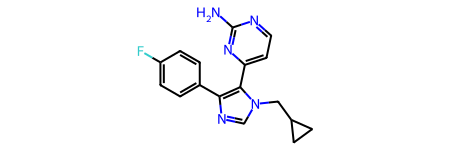

In [7]:
mol.__sssAtoms = None
mol

#### 4. Align a set of stuctures based on their Maxium Common Substructure
When looking at a set of structures and trying to understand SAR, it's often useful to align the structures on a common core.  We can use GenerateDepictionMatchingTemplate to do this. 

In [8]:
from rdkit import Chem
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem

In [9]:
smiles_list = ['CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(OC)cc3C(=O)N)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(OC)cc3C)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(OC)cn3)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(SC)nc3C(=O)N)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cncc(C(=O)N)n3)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cncc(Cl)n3)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cncc(OC)n3)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnccc3C(=O)N)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnccc3C)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnccn3)n2)c(Cl)cc1C(=O)N']

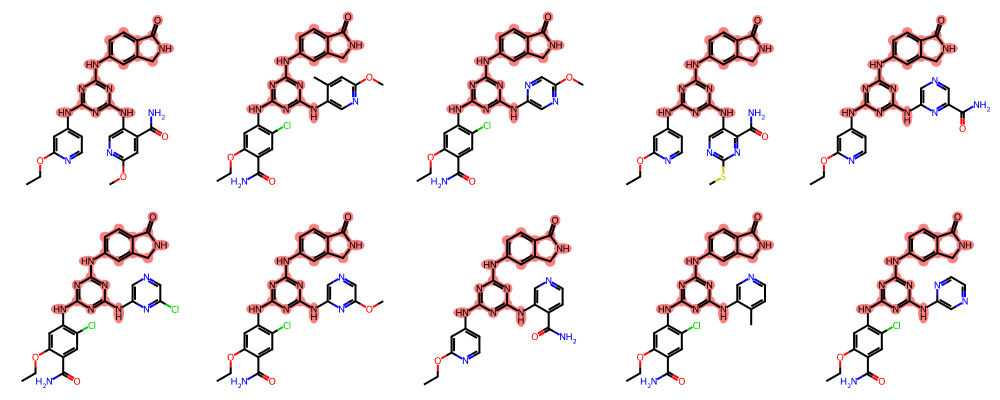

In [10]:
# convert the SMILES to RDKit molecules
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
# define the parameters for the MCS calculation, if we're aligning it's import that the MCS only contains complete rings
params = Chem.rdFMCS.MCSParameters()
params.BondCompareParameters.CompleteRingsOnly=True
params.AtomCompareParameters.CompleteRingsOnly=True
# find the MCS
mcs = FindMCS(mol_list,params)
# get query molecule from the MCS, we will use this as a template for alignment
qmol = mcs.queryMol
# generate coordinates for the template
AllChem.Compute2DCoords(qmol)
# generate coordinates for the molecules using the template
[AllChem.GenerateDepictionMatching2DStructure(m,qmol) for m in mol_list]
# Draw the molecules, highlighting the MCS
MolsToGridImage(mol_list,
                highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mol_list],
                molsPerRow=5)

#### 5. Get the Maximum Common Substructure as SMILES
The function `rdFMCS.GetMCS` return the MCS as SMARTS.  Sometimes we'd like to compare the MCS for several groups of molecules (e.g clusters).  In these cases, it's handy to have the MCS as a SMILES.  The example below shows how to generate a SMILES representation of the MCS. 

In [11]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

We will begin with a list of SMILES and convert it to a list of RDKit molecules. 

In [12]:
smiles_list = ['CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(OC)cc3C(=O)N)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(OC)cc3C)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(OC)cn3)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnc(SC)nc3C(=O)N)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cncc(C(=O)N)n3)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cncc(Cl)n3)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cncc(OC)n3)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnccc3C(=O)N)n2)ccn1',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnccc3C)n2)c(Cl)cc1C(=O)N',
 'CCOc1cc(Nc2nc(Nc3ccc4c(c3)CNC4=O)nc(Nc3cnccn3)n2)c(Cl)cc1C(=O)N']
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]

Now we can calculate the MCS and convert it to SMILES. 
- Set the parameters for the MCS calculation to only include complete rings. Otherwise, we will get aromaticity violations when we try to generate SMILES. 
- Calculate the MCS
- Extract the query molecule from the MCS
- Use the `ExtractSidechains` method to get the scaffold with labeled attachment points.
- Convert the extracted molecule to SMILES.

In [13]:
# set parameters for rdFMCS so that only complete rings are returned
# this helps to avoid an MCS with stray aromatic atoms
params = rdFMCS.MCSParameters()
params.BondCompareParameters.CompleteRingsOnly=True
params.AtomCompareParameters.CompleteRingsOnly=True
# find the MCS
mcs = FindMCS(mol_list, params)
# get the MCS as a query molecule, this isn't what we want
qmol = mcs.queryMol
# match the MCS against the first molecule and delete parts that aren't
# components of the MCS
mcs_mol = Chem.ReplaceSidechains(mol_list[0],qmol)
# get the SMILES for the MCS
mcs_smi = Chem.MolToSmiles(mcs_mol)
mcs_smi

'[1*]Nc1nc(N[2*])nc(Nc2ccc3c(c2)CNC3=O)n1'

#### 6. Assign Bond Orders to a PDB Ligand

I've written about this one before, but it's worth revisiting.  In many cases, we want to read a PDB file and assign bond orders to a ligand structure.  If we know the SMILES for the ligand or if we know the Chemical Identifier (CID) from the PDB, we can use the function `AllChem.AssignBondOrdersFromTemplate` to assign the bond orders from a template molecule we created from the SMILES.  As an example, let's start with the PDB file below.  

In [14]:
pdb_block = """HETATM 2835  FA1 SB5 A 800       7.973  10.854  30.287  1.00 44.81           F
HETATM 2836  CA1 SB5 A 800       6.115  12.249  30.931  1.00 49.28           C
HETATM 2837  CA2 SB5 A 800       6.756  11.394  29.995  1.00 48.31           C
HETATM 2838  CA3 SB5 A 800       6.139  11.100  28.755  1.00 49.84           C
HETATM 2839  CA4 SB5 A 800       4.885  11.662  28.450  1.00 47.39           C
HETATM 2840  CA5 SB5 A 800       4.211  12.533  29.376  1.00 49.11           C
HETATM 2841  CA6 SB5 A 800       4.853  12.814  30.623  1.00 46.49           C
HETATM 2842  CB1 SB5 A 800       1.349   8.914  30.280  1.00 53.54           C
HETATM 2843  NB2 SB5 A 800       0.424   8.416  29.422  1.00 53.65           N
HETATM 2844  CB3 SB5 A 800      -0.061   9.220  28.487  1.00 54.75           C
HETATM 2845  NB4 SB5 A 800       0.276  10.494  28.302  1.00 55.77           N
HETATM 2846  CB5 SB5 A 800       1.210  11.067  29.136  1.00 57.26           C
HETATM 2847  CB6 SB5 A 800       1.797  10.262  30.198  1.00 52.51           C
HETATM 2848  NB7 SB5 A 800      -0.952   8.708  27.683  1.00 52.79           N
HETATM 2849  NC1 SB5 A 800       0.666  13.454  28.386  1.00 60.99           N
HETATM 2850  CC2 SB5 A 800       1.578  12.466  28.945  1.00 60.39           C
HETATM 2851  CC3 SB5 A 800       2.946  13.094  29.027  1.00 55.75           C
HETATM 2852  NC4 SB5 A 800       2.872  14.416  28.563  1.00 57.42           N
HETATM 2853  CC5 SB5 A 800       1.556  14.509  28.230  1.00 61.78           C
HETATM 2854  CD1 SB5 A 800      -0.775  13.379  27.876  1.00 56.89           C
HETATM 2855  CE1 SB5 A 800      -1.090  14.370  26.722  1.00 55.76           C
HETATM 2856  CE2 SB5 A 800      -2.056  13.922  25.620  1.00 58.24           C
HETATM 2857  CE3 SB5 A 800      -0.568  14.023  25.321  1.00 56.03           C
"""

If we parse the PDB file and convert it to an RDKit molecule, we can see that all the bonds are set as single bonds.  This is the default when the RDKit parses a PDB file. 

In [53]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pypdb

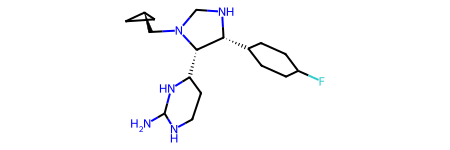

In [54]:
#read a molecule from a PDB block, if you you have pdb file use MolFromPDBFile
mol = Chem.MolFromPDBBlock(pdb_block)
mol

To assign the bond orders, we'll use the following steaps. 
1. Get the CID for the ligand, this is the 4th token on each **HETATM** line.
2. Use pypdb to get the SMILES corresponding to the CID
3. Use `Chem.MolFromSmiles` to generate a template molecule from the SMILES
4. Use `AllChem.AssignBondOrdersFromTemplate` to assign the bond orders

[11:46:11] WARNING: More than one matching pattern found - picking one



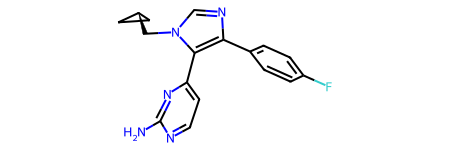

In [55]:
# the CID for the ligand, from the PDB file
cid = "SB5"
# pypdb has a function get the SMILES for the liagand from the CID
tmplt_smiles = pypdb.describe_chemical(f"{cid}")['rcsb_chem_comp_descriptor']['smilesstereo']
# convert tmplt_smiles to an RDKit molecule
tmplt_mol = Chem.MolFromSmiles(tmplt_smiles)
# use tmplt_mol to assign bond orders
bo_mol = AllChem.AssignBondOrdersFromTemplate(tmplt_mol,mol)
bo_mol

<a tag='display-cip-sterechemistry'></a>
#### 7. Display Cahn-Ingold-Prelog Stereochemistry
The RDKit provides an easy, but not obvious, way of putting **R** and **S** labels on a structure. [This post](https://greglandrum.github.io/rdkit-blog/posts/2023-05-26-drawing-options-explained.html) from the RDKit Blog provides a great explanation of the many drawing options. 

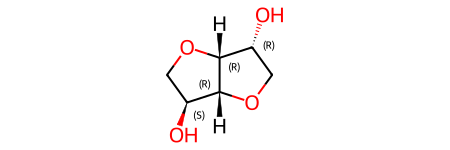

In [56]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addStereoAnnotation = True
smi = "O[C@@H]1CO[C@@H]2[C@@H](O)CO[C@H]12"
Chem.MolFromSmiles(smi)

Of course, setting `addStereoAnnotation` to `False` turns the CIP labels off again. 

In [57]:
IPythonConsole.drawOptions.addStereoAnnotation = False

#### 8. Get the largest fragment in a molecule
In many cases, we want to quickly remove counterions, waters of hydration, or other species that may be present in a molecule.  Note that the code below simply strips out all but the largest species.  If you want to neutralize charges, etc, try [rdMolStandardize](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html). 

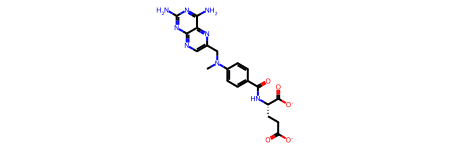

In [58]:
from rdkit import Chem
from operator import itemgetter

smi = "[Na+].[Na+].CN(Cc1cnc2nc(N)nc(N)c2n1)c3ccc(cc3)C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-]"
# convert the SMILES to an RDKit molecule
mol = Chem.MolFromSmiles(smi)
# return a list of connected fragments from the molecule
frag_list = list(Chem.GetMolFrags(mol, asMols=True))
# sort the list of fragements so that the largest is first, note the use of itemgetter to sort by the first list element 
biggest_frag_mol = sorted([(x.GetNumAtoms(), x) for x in frag_list],key=itemgetter(0),reverse=True)[0][1]
biggest_frag_mol

### 9. Create an R-Group Table
The RDKit makes it very easy to generate an R-Group table.  This example mirrors one in the documentation, but a feature as cool as this merits restating. 

In [59]:
from io import StringIO
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem.rdRGroupDecomposition import RGroupDecompose

Create a Pandas dataframe from a csv block using StringIO. 

In [60]:
buff = """ligand_id,SMILES,dG_bind,dG_bind_err
0,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,-2.995,0.455
1,O=C(Nc1ccnc(NC(=O)C2CCCC2)c1)c1ccccc1Cl,8.731,0.462
2,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1ccccc1Cl,3.316,0.448
3,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cc(Cl)cc1Cl,-0.07,0.462
4,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1cc(Cl)ccc1Cl,3.431,0.449
5,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(F)cccc1Cl,-5.422,0.442
6,Nc1cccc(Cl)c1C(=O)Nc1ccnc(NC(=O)C2CC2)c1,7.269,0.444"""
df = pd.read_csv(StringIO(buff))

Create a list of molecules.

In [61]:
mol_list = [Chem.MolFromSmiles(x) for x in df.SMILES]

Create a scaffold molecule.

In [62]:
scaffold = Chem.MolFromSmiles("O=CNc1ccnc(NC=O)c1")

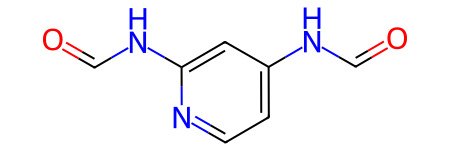

In [63]:
scaffold

Perform the R-Group decompositiion.

In [64]:
rg,_ = RGroupDecompose([scaffold],mol_list,asSmiles=False,asRows=False)

Put the molecules, R-Groups, and the core into a dataframe. 

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,

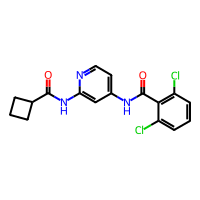
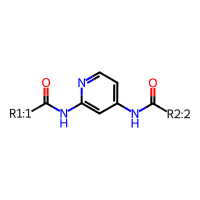
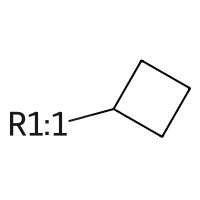
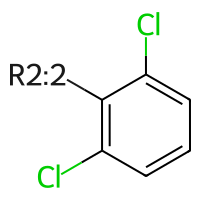
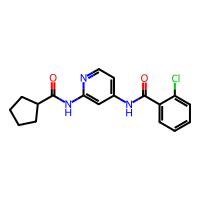
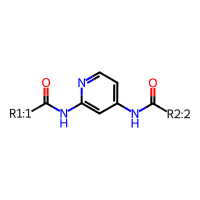
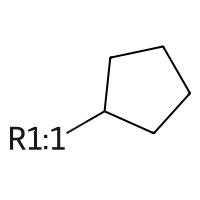
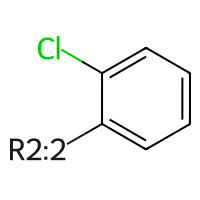
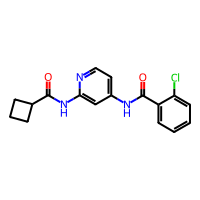
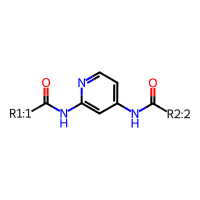
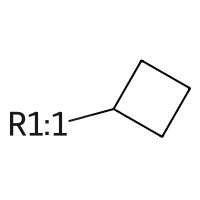
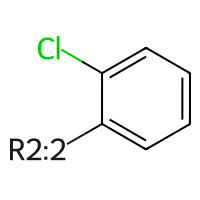
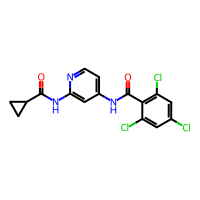
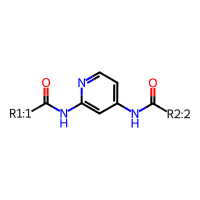
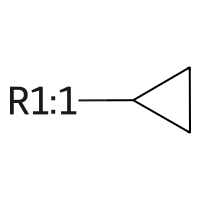
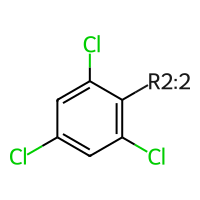
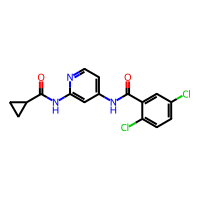
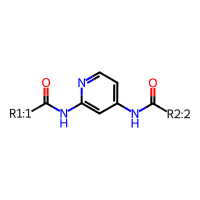
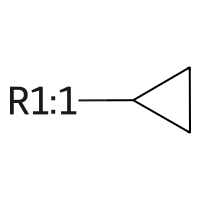
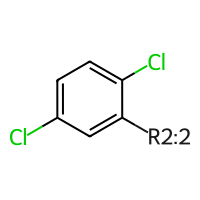
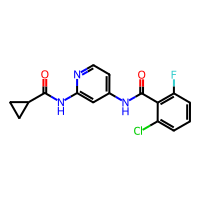
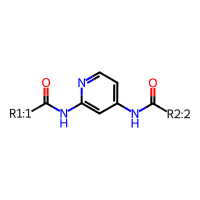
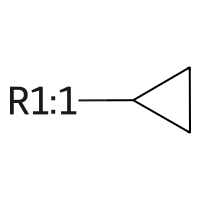
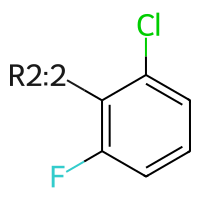
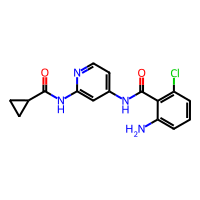
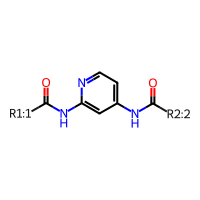
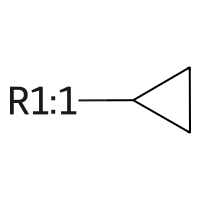
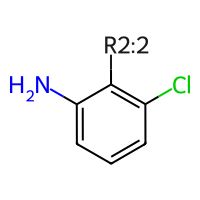

In [65]:
rg_df = PandasTools.RGroupDecompositionToFrame(rg,mol_list,include_core=True)
rg_df

#### 10. Show chemical structures and plots in a Pandas dataframe
In many cases, I want to look at chemical structures together with an image.  For instance, I might want to look at structures, IC50 data, and a dose response curve.  In the example below we'll look at how to add a chemical structutre image and plot to each row in a dataframe.  In this case, the images will be boxplots depicting the similarity of each molecule to all the molecules in the dataset.  

In [66]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from tqdm.auto import tqdm
from IPython.display import HTML

To begin, we'll grab some data.  In this case, a SMILES file containing the structures of some marketed drugs.  For simplicity, we'll only look at 100 compounds. 

In [68]:
sim_df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/datafiles/refs/heads/main/chembl_drugs.smi",
                sep=" ",names=["SMILES","Name"])
sim_df = sim_df.head(100).copy()

We are goign to calculate the Tanimoto similarity of every molecule to each of the molecules in the dataframe.  To do this, we need to instantiate a `rdFingerprintGenerator.MorganGenerator` object, which will calculate Morgan finerprints. 

In [69]:
morgan_generator = rdFingerprintGenerator.GetMorganGenerator()

In [70]:
# initialize the list of images
img_list = []
# create a list of molecules, the method uru.get_largest_fragment is the same as #8 above
mol_list = [uru.get_largest_fragment(Chem.MolFromSmiles(x)) for x in sim_df.SMILES]
# create list of fingerprints
fp_list = list(map(morgan_generator.GetFingerprint,mol_list))
# iterate over molecules and fingerprints and generate images for the molecule, and boxplot of the similarity distribution 
# for the molecule
for mol,fp in tqdm(zip(mol_list,fp_list),total=len(fp_list)):
    # create a list of similarities for this molecule vs all the rest
    sim_list = DataStructs.BulkTanimotoSimilarity(fp, fp_list)
    # create an image of the molecule
    mol_image = uru.mol_to_base64_image(mol)
    # create a boxplot of the distribution in sim_list
    boxplot_image = uru.boxplot_base64_image(sim_list,(0,1.1))    
    # add the images to img_lsit
    img_list.append([mol_image,boxplot_image])

  0%|          | 0/100 [00:00<?, ?it/s]

Add the images to the dataframe. 

In [72]:
sim_df[['mol_image','boxplot_image']] = img_list

Display the dataframe with the images. I didn't fee the SMILES were helpful for this visualization, so I dropped that column from the dataframe when displaying it. 


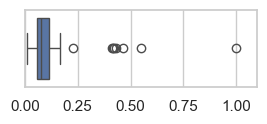
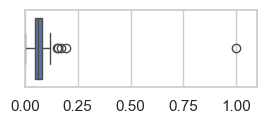
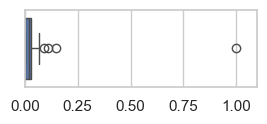
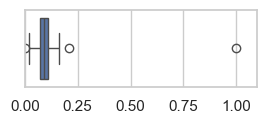
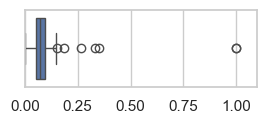
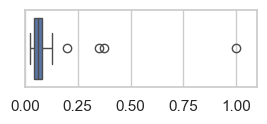
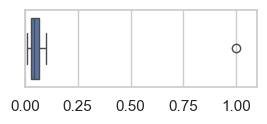
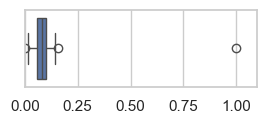
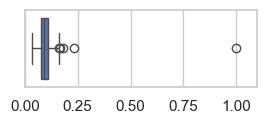
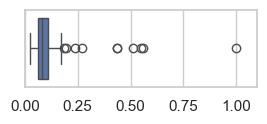

In [73]:
HTML(sim_df.drop(columns=["SMILES"]).head(10).to_html(escape=False))